In [ ]:
#BIBLIOHGRAFIA
print ='''-https://www.kaggle.com/datasets/abdulrahmankerim/crash-car-image-hybrid-dataset-ccih
   -Tan, M., & Le, Q. V. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. Proceedings of the 36th International Conference on Machine Learning, PMLR 97, 6105-6114. arXiv:1905.11946
   -He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770-778. arXiv:1512.03385
   -Simonyan, K., & Zisserman, A. (2015). Very Deep Convolutional Networks for Large-Scale Image Recognition. International Conference on Learning Representations (ICLR). arXiv:1409.1556
   -Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. International Conference on Learning Representations (ICLR). arXiv:2010.11929
   -Howard, A., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., ... & Adam, H. (2017). MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications. arXiv:1704.04861
'''

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("GPU")
physical_devices = tf.config.list_physical_devices('GPU')
print(f"GPUs físicas encontradas: {len(physical_devices)}")

if len(physical_devices) > 0:
    for i, gpu in enumerate(physical_devices):
        print(f"   GPU {i}: {gpu}")
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"MemoriaGPU {i}")
        except RuntimeError as e:
            print(f"GPU {i}: {str(e)}")
            print(f"Ya optimizado")
else:
    print("Usando GPU")

try:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Estrategia distribuida: {strategy.num_replicas_in_sync} GPUs")
except:
    strategy = tf.distribute.get_strategy()  
    print("Usando estrategia por defecto (CPU)")


class Config:
#Importacion del set de datos, xtraido de kaggle.
    DATASET_PATH = "/kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH"
    #Paths del dat seth
    TRAIN_PATH = os.path.join(DATASET_PATH, "train")
    EVAL_PATH = os.path.join(DATASET_PATH, "valid")  
    TEST_PATH = os.path.join(DATASET_PATH, "test")
    
    # Configuración del modelo
    MODEL_NAME = "EfficientNet-B3"
    INPUT_SIZE = (300, 300)
    CHANNELS = 3
    INPUT_SHAPE = (*INPUT_SIZE, CHANNELS)
    
    # Configuración de entrenamiento 
    BASE_BATCH_SIZE = 20  
    BATCH_SIZE = BASE_BATCH_SIZE * strategy.num_replicas_in_sync
    EPOCHS = 60
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 0.01
    EARLY_STOPPING_PATIENCE = 10
    REDUCE_LR_PATIENCE = 5
    REDUCE_LR_FACTOR = 0.5
    ROTATION_RANGE = 15
    WIDTH_SHIFT_RANGE = 0.1
    HEIGHT_SHIFT_RANGE = 0.1
    ZOOM_RANGE = 0.1
    HORIZONTAL_FLIP = True
    CLASSES = ['Acc', 'Nat'] 
    NUM_CLASSES = len(CLASSES)
    VALIDATION_SPLIT = 0.2
    MODEL_SAVE_PATH = "best_efficientnet_b3_ccih.h5"
print("\n" + "="*60)
print("CONFIGURACIÓN DEL EXPERIMENTO")
print("="*60)
print(f"Dataset path: {Config.DATASET_PATH}")
print(f"Modelo: {Config.MODEL_NAME}")
print(f"Input shape: {Config.INPUT_SHAPE}")
print(f"Batch size total: {Config.BATCH_SIZE} ({Config.BASE_BATCH_SIZE} por GPU × {strategy.num_replicas_in_sync} GPUs)")
print(f"Epochs: {Config.EPOCHS}")
print(f"Learning rate: {Config.LEARNING_RATE}")
print(f"Weight decay: {Config.WEIGHT_DECAY}")
print(f"Clases: {Config.CLASSES}")
print("="*60)


paths_to_check = [Config.TRAIN_PATH, Config.EVAL_PATH, Config.TEST_PATH]
for path in paths_to_check:
    if os.path.exists(path):
        print(f"✅ {path} - Existe")
    else:
        print(f"❌ {path} - No existe")
        
def count_images_in_path(path):
    """Cuenta imágenes en cada clase dentro de un path"""
    counts = {}
    if os.path.exists(path):
        for class_name in Config.CLASSES:
            class_path = os.path.join(path, class_name)
            if os.path.exists(class_path):
                image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
                count = sum(1 for f in os.listdir(class_path) 
                           if any(f.lower().endswith(ext) for ext in image_extensions))
                counts[class_name] = count
            else:
                counts[class_name] = 0
    return counts

train_counts = count_images_in_path(Config.TRAIN_PATH)
valid_counts = count_images_in_path(Config.EVAL_PATH)  
test_counts = count_images_in_path(Config.TEST_PATH)

print(f"\nDATASET:")
print(f"Train: acc={train_counts.get('acc', 0)}, nat={train_counts.get('nat', 0)}")
print(f"Valid: acc={valid_counts.get('acc', 0)}, nat={valid_counts.get('nat', 0)}")  
print(f"Test:  acc={test_counts.get('acc', 0)}, nat={test_counts.get('nat', 0)}")


total_train = sum(train_counts.values())
total_valid = sum(valid_counts.values())  
total_test = sum(test_counts.values())
total_images = total_train + total_valid + total_test
print(f"Total imágenes: {total_images}")

if total_images > 0:
    print(f"Train: {total_train} ({total_train/total_images*100:.1f}%)")
    print(f"Valid: {total_valid} ({total_valid/total_images*100:.1f}%)")
    print(f"Test: {total_test} ({total_test/total_images*100:.1f}%)")
else:
    print("No")
    
    print(f"\nESTRUCTURA REAL:")
    for root, dirs, files in os.walk(Config.DATASET_PATH):
        level = root.replace(Config.DATASET_PATH, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]: 
            print(f"{subindent}{file}")
        if len(files) > 3:
            print(f"{subindent}... y {len(files)-3} archivos más")

print("\n COMPLETADO")

GPU
GPUs físicas encontradas: 2
   GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
MemoriaGPU 0
   GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
MemoriaGPU 1
Estrategia distribuida: 2 GPUs

CONFIGURACIÓN DEL EXPERIMENTO
Dataset path: /kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH
Modelo: EfficientNet-B3
Input shape: (300, 300, 3)
Batch size total: 40 (20 por GPU × 2 GPUs)
Epochs: 60
Learning rate: 0.001
Weight decay: 0.01
Clases: ['Acc', 'Nat']
✅ /kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH/train - Existe
✅ /kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH/valid - Existe
✅ /kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH/test - Existe

DATASET:
Train: acc=0, nat=0
Valid: acc=0, nat=0
Test:  acc=0, nat=0
Total imágenes: 850
Train: 540 (63.5%)
Valid: 122 (14.4%)
Test: 188 (22.1%)

 COMPLETADO


/kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH/train/Acc: 270 imágenes
/kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH/train/Nat: 270 imágenes
/kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH/valid/Acc: 61 imágenes
/kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH/valid/Nat: 61 imágenes
/kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH/test/Acc: 94 imágenes
/kaggle/input/crash-car-image-hybrid-dataset-ccih/CCIH/test/Nat: 94 imágenes

DISTRIBUCIÓN FINAL:
Train: Acc=270, Nat=270 | Total: 540
Valid: Acc=61, Nat=61 | Total: 122
Test:  Acc=94, Nat=94 | Total: 188
TOTAL: 850 imágenes

PORCENTAJES:
Train: 540 (63.5%)
Valid: 122 (14.4%)
Test: 188 (22.1%)

BALANCE DE CLASES:
Accidentados (Acc): 425 (50.0%)
Normales (Nat): 425 (50.0%)
balanceado (ratio: 1.00)

🖼️  GENERANDO VISUALIZACIÓN DE MUESTRAS...


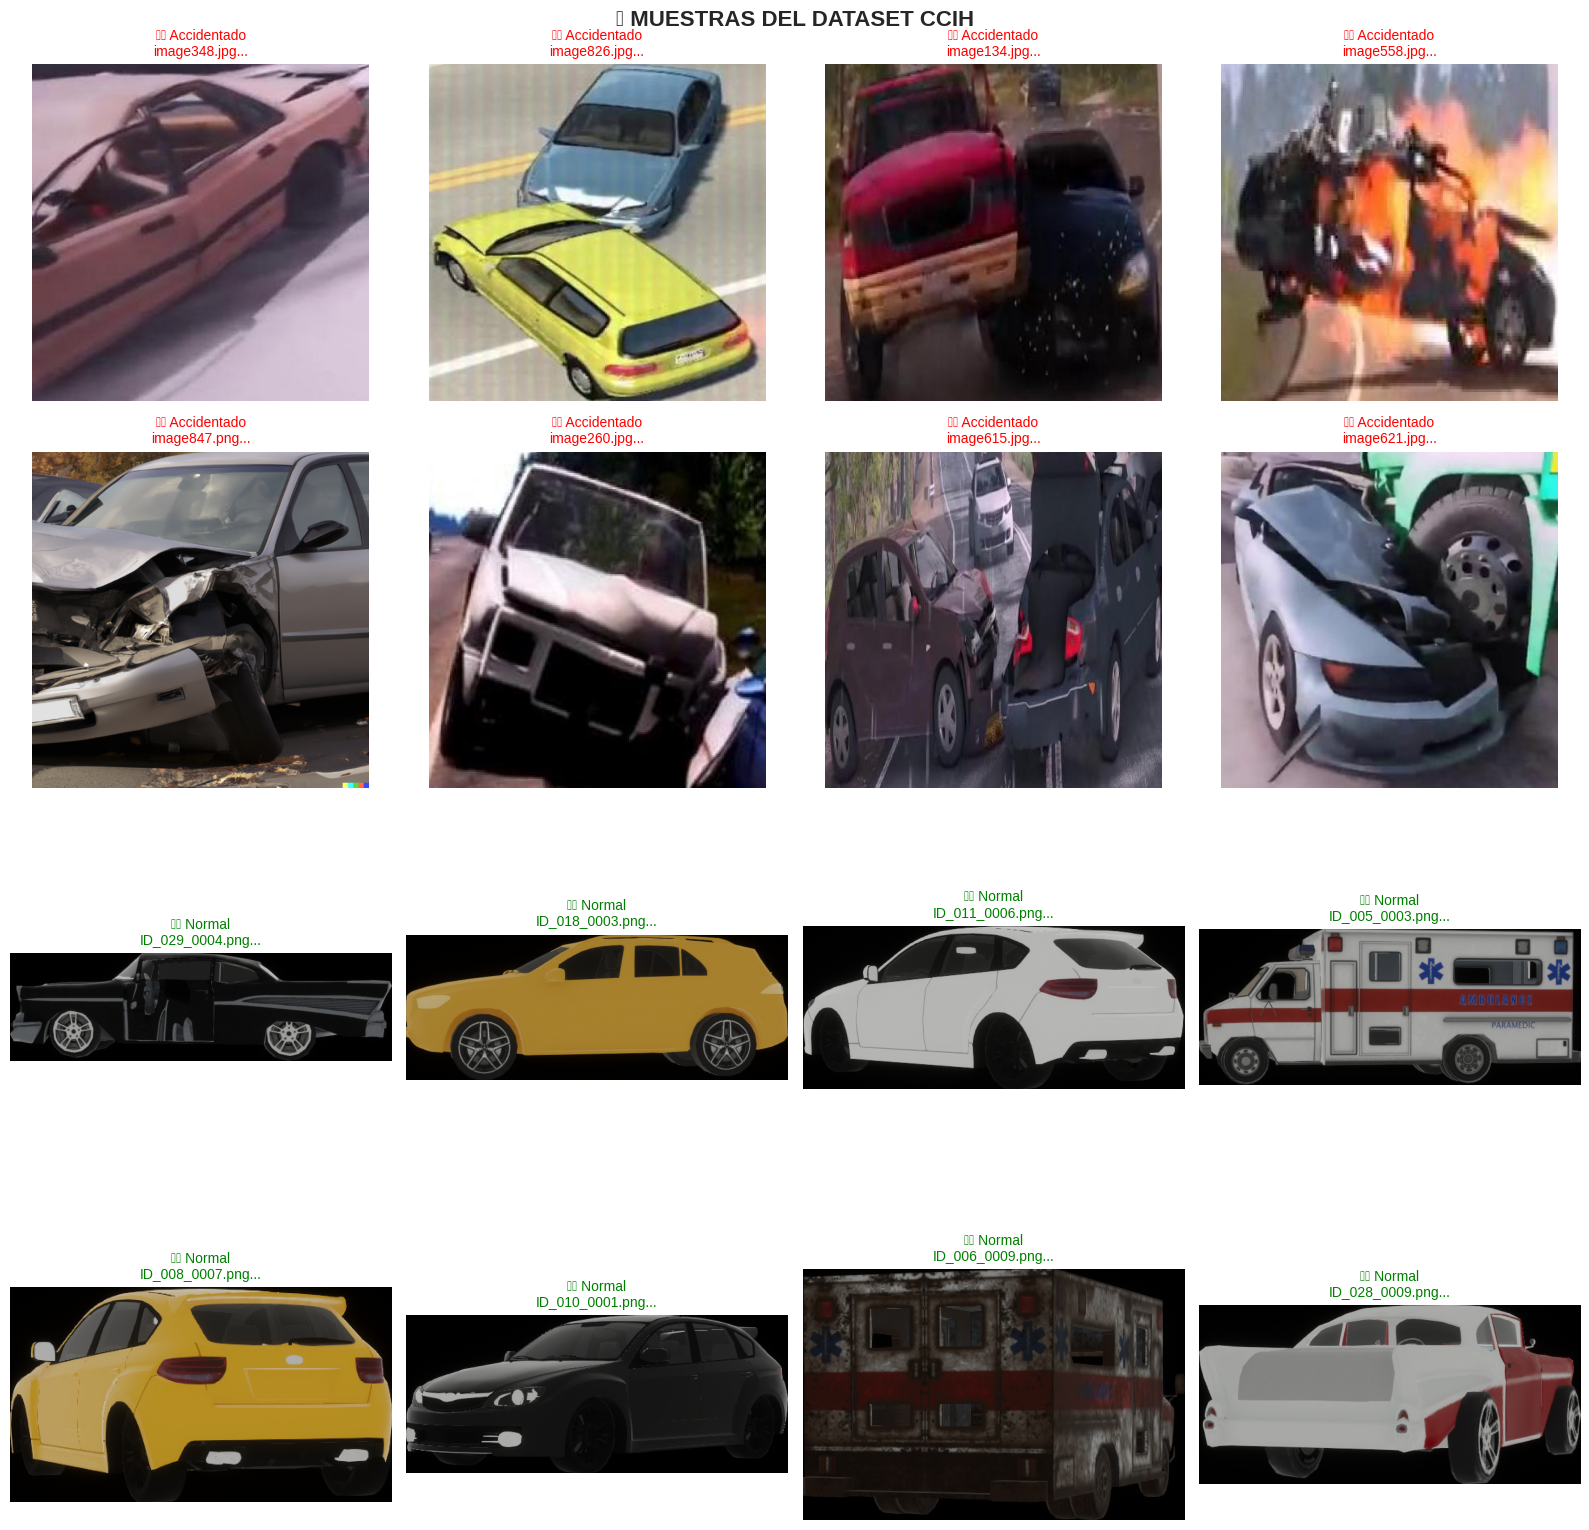


PROPIEDADES DE IMÁGENES:

ACCIDENTADOS (50 muestras analizadas):
Tamaños (W×H):
Min: 416×416
Max: 1024×1024
Promedio: 465×465
Formatos: {'JPEG': 46, 'PNG': 4}
Modos: {'RGB': 50}

NORMALES (50 muestras analizadas):
Tamaños (W×H):
Min: 308×222
Max: 891×512
Promedio: 582×286
Formatos: {'PNG': 44, 'JPEG': 6}
Modos: {'RGB': 50}


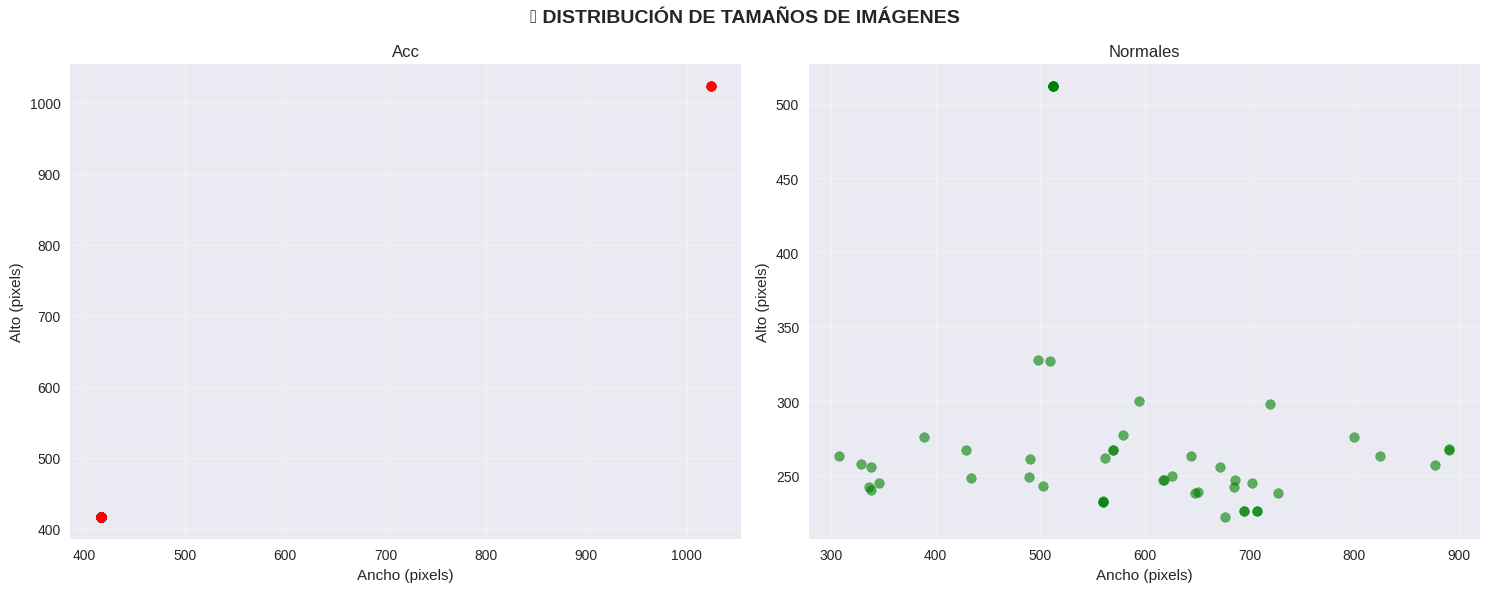


TAMAÑO:
Ancho - Min: 308, Max: 1024, Promedio: 524
Alto - Min: 222, Max: 1024, Promedio: 375


In [ ]:
def count_images_correctly(path):
    counts = {}
    if os.path.exists(path):
        for class_name in Config.CLASSES:  
            class_path = os.path.join(path, class_name)
            if os.path.exists(class_path):
                image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
                files = os.listdir(class_path)
                count = sum(1 for f in files 
                           if any(f.lower().endswith(ext) for ext in image_extensions))
                counts[class_name] = count
                print(f"{class_path}: {count} imágenes")
            else:
                counts[class_name] = 0
                print(f"  {class_path}: No existe")
    return counts

print("="*50)

train_counts = count_images_correctly(Config.TRAIN_PATH)
valid_counts = count_images_correctly(Config.EVAL_PATH)
test_counts = count_images_correctly(Config.TEST_PATH)
total_train = sum(train_counts.values())
total_valid = sum(valid_counts.values())
total_test = sum(test_counts.values())
total_images = total_train + total_valid + total_test

print(f"\nDISTRIBUCIÓN FINAL:")
print(f"Train: Acc={train_counts.get('Acc', 0)}, Nat={train_counts.get('Nat', 0)} | Total: {total_train}")
print(f"Valid: Acc={valid_counts.get('Acc', 0)}, Nat={valid_counts.get('Nat', 0)} | Total: {total_valid}")
print(f"Test:  Acc={test_counts.get('Acc', 0)}, Nat={test_counts.get('Nat', 0)} | Total: {total_test}")
print(f"TOTAL: {total_images} imágenes")

if total_images > 0:
    print(f"\nPORCENTAJES:")
    print(f"Train: {total_train} ({total_train/total_images*100:.1f}%)")
    print(f"Valid: {total_valid} ({total_valid/total_images*100:.1f}%)")
    print(f"Test: {total_test} ({total_test/total_images*100:.1f}%)") 
    total_acc = train_counts.get('Acc', 0) + valid_counts.get('Acc', 0) + test_counts.get('Acc', 0)
    total_nat = train_counts.get('Nat', 0) + valid_counts.get('Nat', 0) + test_counts.get('Nat', 0)
    
    print(f"\nBALANCE DE CLASES:")
    print(f"Accidentados (Acc): {total_acc} ({total_acc/total_images*100:.1f}%)")
    print(f"Normales (Nat): {total_nat} ({total_nat/total_images*100:.1f}%)")
    
    balance_ratio = min(total_acc, total_nat) / max(total_acc, total_nat)
    if balance_ratio > 0.8:
        print(f"balanceado (ratio: {balance_ratio:.2f})")
    elif balance_ratio > 0.6:
        print(f"Ligero(ratio: {balance_ratio:.2f})")
    else:
        print(f"Desbalance (ratio: {balance_ratio:.2f}) - Considerar class weights")

import random
from PIL import Image

def load_sample_images(path, class_name, n_samples=4):
    """Carga muestras aleatorias de una clase"""
    class_path = os.path.join(path, class_name)
    if not os.path.exists(class_path):
        return []
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(class_path) 
                   if any(f.lower().endswith(ext) for ext in image_extensions)]
    
    if len(image_files) < n_samples:
        n_samples = len(image_files)
    
    selected_files = random.sample(image_files, n_samples)
    
    images = []
    for file in selected_files:
        try:
            img_path = os.path.join(class_path, file)
            img = Image.open(img_path)
            images.append((img, file))
        except Exception as e:
            print(f"⚠️  Error cargando {file}: {e}")
    
    return images

def plot_sample_images():
    """Visualiza muestras del dataset"""
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('🔍 MUESTRAS DEL DATASET CCIH', fontsize=16, fontweight='bold')
    
    acc_samples = load_sample_images(Config.TRAIN_PATH, 'Acc', 8)
    nat_samples = load_sample_images(Config.TRAIN_PATH, 'Nat', 8)
    
    for i in range(min(8, len(acc_samples))):
        row = i // 4
        col = i % 4
        if i < len(acc_samples):
            img, filename = acc_samples[i]
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'🚗💥 Accidentado\n{filename[:20]}...', 
                                   fontsize=10, color='red')
            axes[row, col].axis('off')
    
    for i in range(min(8, len(nat_samples))):
        row = (i // 4) + 2  # Filas 2 y 3
        col = i % 4
        if i < len(nat_samples):
            img, filename = nat_samples[i]
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'🚗✅ Normal\n{filename[:20]}...', 
                                   fontsize=10, color='green')
            axes[row, col].axis('off')
    
    for i in range(4):
        for j in range(4):
            if (i < 2 and (i*4 + j) >= len(acc_samples)) or \
               (i >= 2 and ((i-2)*4 + j) >= len(nat_samples)):
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nMuestra de Imagenes")
random.seed(42) 
plot_sample_images()


def analyze_image_properties(path, class_name, max_samples=50):
    class_path = os.path.join(path, class_name)
    if not os.path.exists(class_path):
        return {}
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(class_path) 
                   if any(f.lower().endswith(ext) for ext in image_extensions)]
    
    if len(image_files) > max_samples:
        image_files = random.sample(image_files, max_samples)
    
    sizes = []
    formats = []
    modes = []
    
    for file in image_files:
        try:
            img_path = os.path.join(class_path, file)
            with Image.open(img_path) as img:
                sizes.append(img.size)  
                formats.append(img.format)
                modes.append(img.mode)
        except Exception as e:
            print(f"Error {file}: {e}")
    
    return {
        'sizes': sizes,
        'formats': formats,
        'modes': modes,
        'count': len(sizes)
    }

print("\nPROPIEDADES DE IMÁGENES:")
print("="*50)

acc_props = analyze_image_properties(Config.TRAIN_PATH, 'Acc')
nat_props = analyze_image_properties(Config.TRAIN_PATH, 'Nat')

def print_image_stats(props, class_name):
    """Imprime estadísticas de imágenes"""
    if not props or not props['sizes']:
        print(f"No se pudo analizar {class_name}")
        return
    
    sizes = props['sizes']
    widths = [s[0] for s in sizes]
    heights = [s[1] for s in sizes]
    
    print(f"\n{class_name.upper()} ({props['count']} muestras analizadas):")
    print(f"Tamaños (W×H):")
    print(f"Min: {min(widths)}×{min(heights)}")
    print(f"Max: {max(widths)}×{max(heights)}")
    print(f"Promedio: {np.mean(widths):.0f}×{np.mean(heights):.0f}")
    
    format_counts = {}
    for fmt in props['formats']:
        format_counts[fmt] = format_counts.get(fmt, 0) + 1
    
    print(f"Formatos: {dict(format_counts)}")
    
    # Modos de color
    mode_counts = {}
    for mode in props['modes']:
        mode_counts[mode] = mode_counts.get(mode, 0) + 1
    
    print(f"Modos: {dict(mode_counts)}")

print_image_stats(acc_props, "Accidentados")
print_image_stats(nat_props, "Normales")


if acc_props['sizes'] and nat_props['sizes']:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('TAMAÑOS DE IMÁGENES', fontsize=14, fontweight='bold')
    
    acc_widths = [s[0] for s in acc_props['sizes']]
    acc_heights = [s[1] for s in acc_props['sizes']]
    
    axes[0].scatter(acc_widths, acc_heights, alpha=0.6, color='red', label='Acc')
    axes[0].set_xlabel('Ancho (pixels)')
    axes[0].set_ylabel('Alto (pixels)')
    axes[0].set_title('Acc')
    axes[0].grid(True, alpha=0.3)
    
    # Normales
    nat_widths = [s[0] for s in nat_props['sizes']]
    nat_heights = [s[1] for s in nat_props['sizes']]
    
    axes[1].scatter(nat_widths, nat_heights, alpha=0.6, color='green', label='Normales')
    axes[1].set_xlabel('Ancho (pixels)')
    axes[1].set_ylabel('Alto (pixels)')
    axes[1].set_title('Normales')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    all_widths = acc_widths + nat_widths
    all_heights = acc_heights + nat_heights
    
    print(f"\nTAMAÑO:")
    print(f"Ancho - Min: {min(all_widths)}, Max: {max(all_widths)}, Promedio: {np.mean(all_widths):.0f}")
    print(f"Alto - Min: {min(all_heights)}, Max: {max(all_heights)}, Promedio: {np.mean(all_heights):.0f}")
    

🔄 CONFIGURANDO PIPELINE DE DATOS...
✅ Data Generators configurados
   🔄 Train: Augmentation activada
   🎯 Valid: Solo normalización
   🧪 Test:  Solo normalización

📁 CONFIGURANDO GENERADORES DESDE DIRECTORIOS...
Found 540 images belonging to 2 classes.
Found 122 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
✅ Generadores configurados exitosamente
   🏋️  Train: 540 muestras, 14 batches
   🎯 Valid: 122 muestras, 4 batches
   🧪 Test:  188 muestras, 5 batches

🏷️  MAPEO DE CLASES:
   {'Acc': 0, 'Nat': 1}
   Acc (accidentado) = 0
   Nat (normal) = 1

🔍 VERIFICANDO PIPELINE...
✅ Batch de entrenamiento:
   📐 Shape: (40, 300, 300, 3)
   📊 Labels shape: (40,)
   📈 Pixel range: [0.000, 1.000]
   🏷️  Labels únicos: [0. 1.]
✅ Batch de validación:
   📐 Shape: (40, 300, 300, 3)
   📊 Labels shape: (40,)
   📈 Pixel range: [0.000, 1.000]
   🏷️  Labels únicos: [0.]

⚖️  DISTRIBUCIÓN EN BATCH DE ENTRENAMIENTO:
   Accidentados (0): 20/40 (50.0%)
   Normales (1): 20/40 (50.0%)

🖼️

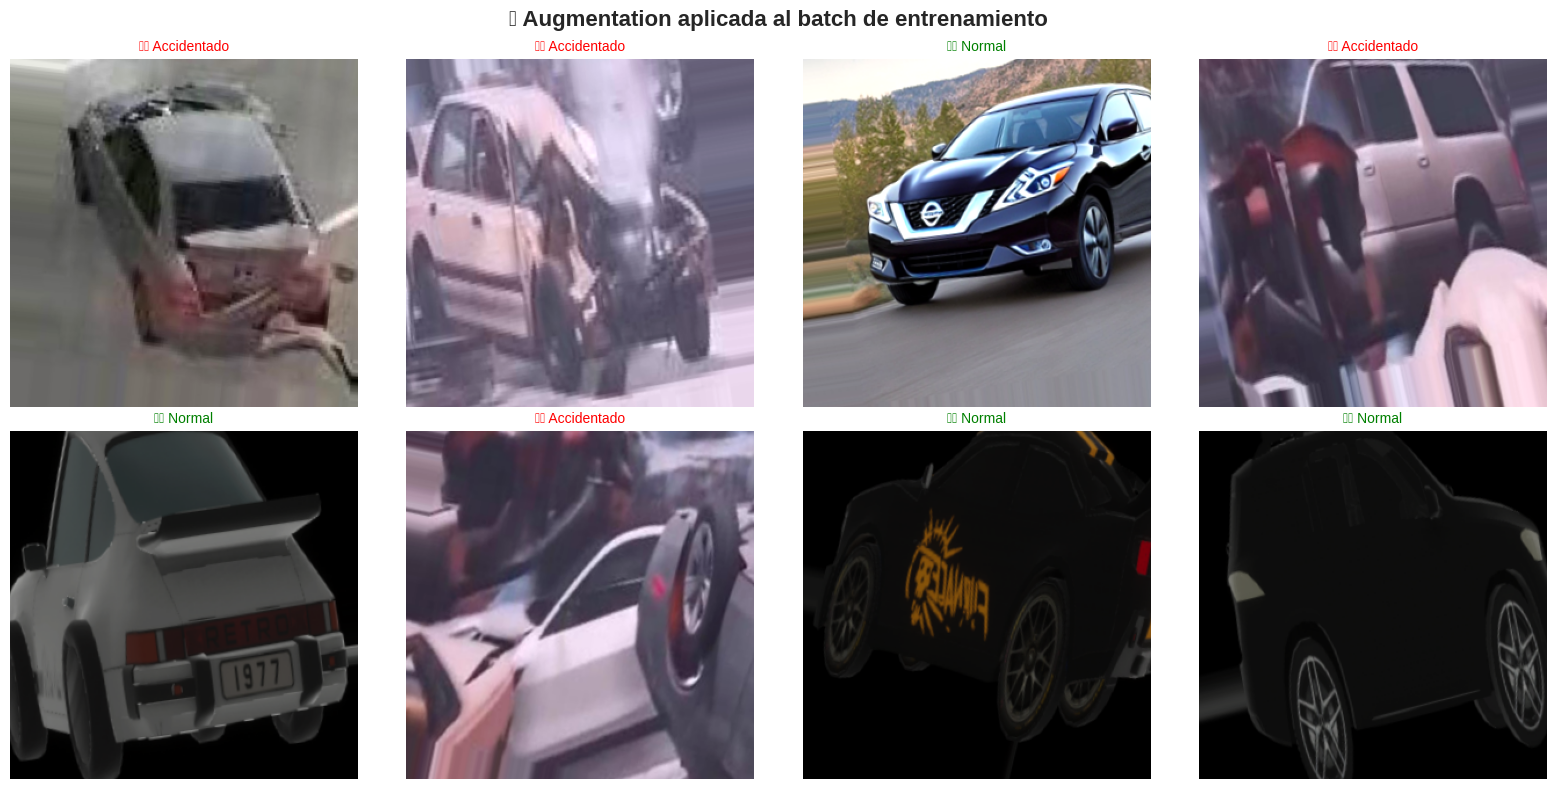


📊 COMPARANDO ORIGINAL vs AUGMENTED...
Found 540 images belonging to 2 classes.
Found 540 images belonging to 2 classes.


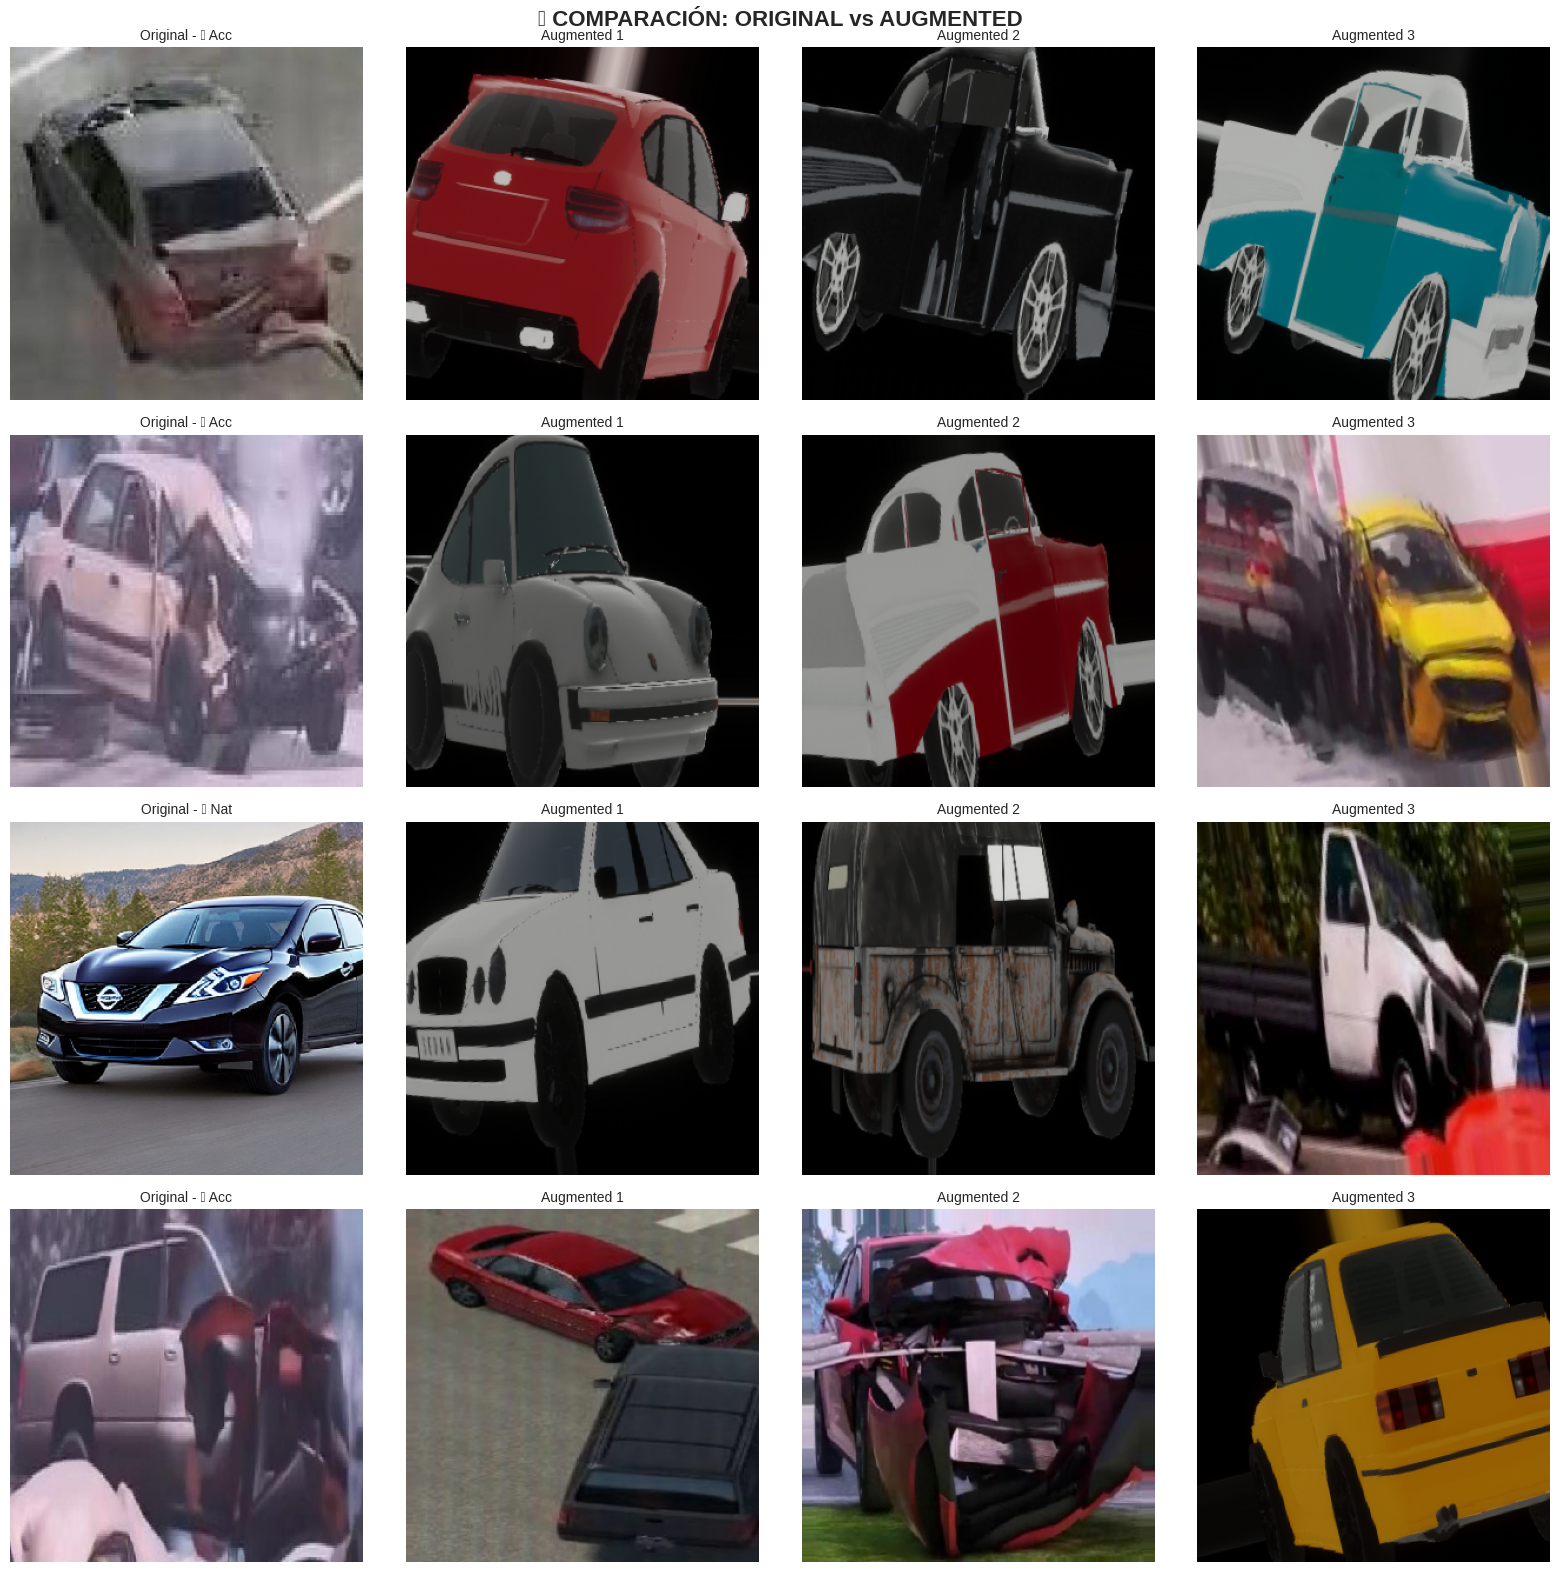


🚀 CONFIGURACIÓN PARA DISTRIBUTED TRAINING...
📈 CONFIGURACIÓN DE TRAINING:
   🏋️  Steps per epoch: 14
   🎯 Validation steps: 4
   📊 Batch size total: 40
   🔄 Epochs planificados: 60
   ⏱️  Tiempo estimado por epoch: ~7.0 segundos
⚖️  CLASS WEIGHTS CALCULADOS:
   Acc (idx 0): 1.000
   Nat (idx 1): 1.000
✅ Dataset bien balanceado (ratio: 1.000) - Class weights opcionales

✅ PIPELINE DE DATOS COMPLETADO
🔧 CONFIGURACIÓN FINAL:
   📁 Train samples: 540
   📁 Valid samples: 122
   📁 Test samples: 188
   📐 Input shape: (300, 300, 3)
   🎯 Batch size: 40
   ⚖️  Use class weights: False
   🔄 Augmentation: Activada para training
✅ PIPELINE LISTO - Proceder al Bloque 4: Construcción del Modelo


In [ ]:
print("="*60)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    
    # Aumentaciones geométricas
    rotation_range=Config.ROTATION_RANGE,          # 15° rotación
    width_shift_range=Config.WIDTH_SHIFT_RANGE,    # 10% shift horizontal
    height_shift_range=Config.HEIGHT_SHIFT_RANGE,  # 10% shift vertical
    zoom_range=Config.ZOOM_RANGE,                  # 10% zoom in/out
    horizontal_flip=Config.HORIZONTAL_FLIP,        # Flip horizontal
    
    shear_range=0.1,                              # Distorsión geométrica
    brightness_range=[0.8, 1.2],                 # Variación de brillo 
    channel_shift_range=0.1,                     # Variación de canales de color
    
    # Configuración de filling
    fill_mode='nearest',                          # Relleno de píxeles
)

valid_datagen = ImageDataGenerator(
    rescale=1./255  
)
test_datagen = ImageDataGenerator(
    rescale=1./255  #
)

print("Data Generators configurados")
print(f" Train: Augmentation activada")
print(f"Valid: Solo normalización")
print(f"Test:  Solo normalización")

#Genenrador ENTRENAMIENTO
train_generator = train_datagen.flow_from_directory(
    Config.TRAIN_PATH,
    target_size=Config.INPUT_SIZE,               # (300, 300)
    batch_size=Config.BATCH_SIZE,               # 40 (20 por GPU)
    class_mode='binary',                        # Clasificación binaria
    classes=['Acc', 'Nat'],                    
    shuffle=True,                               # Mezclar datos
    seed=42,                                    # Reproducibilidad
    color_mode='rgb',                           # 3 canales
    interpolation='bilinear'                    # Mejor calidad de resize
)

# Generador de VALIDACIÓN
valid_generator = valid_datagen.flow_from_directory(
    Config.EVAL_PATH,                           # Usar 'valid' folder
    target_size=Config.INPUT_SIZE,
    batch_size=Config.BATCH_SIZE,               # Mismo batch size
    class_mode='binary',
    classes=['Acc', 'Nat'],                    # Mismo orden
    shuffle=False,                              # NO mezclar validación
    seed=42,
    color_mode='rgb',
    interpolation='bilinear'
)

# Generador de TEST
test_generator = test_datagen.flow_from_directory(
    Config.TEST_PATH,
    target_size=Config.INPUT_SIZE,
    batch_size=Config.BATCH_SIZE,
    class_mode='binary',
    classes=['Acc', 'Nat'],
    shuffle=False,                              # NO mezclar test
    seed=42,
    color_mode='rgb',
    interpolation='bilinear'
)

print("Generadores")
print(f"Train: {train_generator.samples} muestras, {len(train_generator)} batches")
print(f"Valid: {valid_generator.samples} muestras, {len(valid_generator)} batches")
print(f"Test:  {test_generator.samples} muestras, {len(test_generator)} batches")

# Verificar mapeo de clases
print(f"\nCLASES:")
print(f"   {train_generator.class_indices}")
print(f"   Acc (accidentado) = {train_generator.class_indices['Acc']}")
print(f"   Nat (normal) = {train_generator.class_indices['Nat']}")

def verify_data_pipeline():
    """Verifica que el pipeline funcione correctamente"""
    try:
        train_batch_x, train_batch_y = next(train_generator)
        
        # Obtener un  de validación
        valid_batch_x, valid_batch_y = next(valid_generator)
        
        print(f"Batch de entrenamiento:")
        print(f"Shape: {train_batch_x.shape}")
        print(f" Labels shape: {train_batch_y.shape}")
        print(f" Pixel range: [{train_batch_x.min():.3f}, {train_batch_x.max():.3f}]")
        print(f"Labels únicos: {np.unique(train_batch_y)}")
        
        print(f"Batch de validación:")
        print(f"Shape: {valid_batch_x.shape}")
        print(f"Labels shape: {valid_batch_y.shape}")
        print(f"Pixel range: [{valid_batch_x.min():.3f}, {valid_batch_x.max():.3f}]")
        print(f"Labels únicos: {np.unique(valid_batch_y)}")
        
        train_acc_count = np.sum(train_batch_y == 0)  # Acc = 0
        train_nat_count = np.sum(train_batch_y == 1)  # Nat = 1
        
        print(f"\nBATCH DE ENTRENAMIENTO:")
        print(f"   Accidentados (0): {train_acc_count}/{len(train_batch_y)} ({train_acc_count/len(train_batch_y)*100:.1f}%)")
        print(f"   Normales (1): {train_nat_count}/{len(train_batch_y)} ({train_nat_count/len(train_batch_y)*100:.1f}%)")
        
        return train_batch_x, train_batch_y, valid_batch_x, valid_batch_y
        
    except Exception as e:
        print(f"Error {e}")
        return None, None, None, None

train_x, train_y, valid_x, valid_y = verify_data_pipeline()

def visualize_augmentation(generator, title="Data Augmentation"):
    """Visualiza el efecto del data augmentation"""
    if train_x is None:
        print("No se pudo visualizar")
        return
    
    # Tomar las primeras 8 imágenes del batch
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'🔄 {title}', fontsize=16, fontweight='bold')
    
    for i in range(min(8, len(train_x))):
        row = i // 4
        col = i % 4
        
        # Mostrar imagen (ya está normalizada [0,1])
        axes[row, col].imshow(train_x[i])
        
        # Título con clase
        class_name = "Acc" if train_y[i] == 0 else "Normal"
        color = 'red' if train_y[i] == 0 else 'green'
        axes[row, col].set_title(class_name, color=color, fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

print(f"\naUMENTACION")
if train_x is not None:
    visualize_augmentation(train_generator, "Augmentation aplicada al batch de entrenamiento")


def compare_original_vs_augmented():
    """Compara imágenes originales vs augmentadas"""
    no_aug_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        Config.TRAIN_PATH,
        target_size=Config.INPUT_SIZE,
        batch_size=8,
        class_mode='binary',
        classes=['Acc', 'Nat'],
        shuffle=True,
        seed=42
    )
    
    aug_gen = train_datagen.flow_from_directory(
        Config.TRAIN_PATH,
        target_size=Config.INPUT_SIZE,
        batch_size=8,
        class_mode='binary',
        classes=['Acc', 'Nat'],
        shuffle=True,
        seed=42
    )
    
    try:
        orig_x, orig_y = next(no_aug_gen)
        aug_x, aug_y = next(aug_gen)
        
        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        fig.suptitle(' ORIGINAL vs AUGMENTED', fontsize=16, fontweight='bold')
        
        for i in range(min(4, len(orig_x))):
            axes[i, 0].imshow(orig_x[i])
            class_name = "Acc" if orig_y[i] == 0 else "Nat"
            axes[i, 0].set_title(f'Original - {class_name}', fontsize=10)
            axes[i, 0].axis('off')
            
            # Augmented (3 versiones)
            for j in range(3):
                aug_batch_x, aug_batch_y = next(aug_gen)
                axes[i, j+1].imshow(aug_batch_x[i])
                axes[i, j+1].set_title(f'Augmented {j+1}', fontsize=10)
                axes[i, j+1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"ror en comparación: {e}")

print(f"\nORIGINAL vs AUGMENTED...")
compare_original_vs_augmented()


print(f"\nTRAINING...")

steps_per_epoch = len(train_generator)
validation_steps = len(valid_generator)

print(f"CONFIGURACIÓN:")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Batch size total: {Config.BATCH_SIZE}")
print(f"Epochs planificados: {Config.EPOCHS}")
print(f"Tiempo estimado por epoch: ~{steps_per_epoch * 0.5:.1f} segundos")

# Calcular class weights si es necesario
def calculate_class_weights():
    """Calcula class weights para balance de clases"""
    # Obtener distribución real del generador
    class_counts = {}
    total_samples = train_generator.samples
    
    for class_name, class_idx in train_generator.class_indices.items():
        # Contar archivos en cada carpeta
        class_path = os.path.join(Config.TRAIN_PATH, class_name)
        count = len([f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        class_counts[class_idx] = count
    
    # Calcular weights
    max_count = max(class_counts.values())
    class_weights = {class_idx: max_count / count 
                    for class_idx, count in class_counts.items()}
    
    print(f"wEIGHTS CALCULADOS:")
    for class_name, class_idx in train_generator.class_indices.items():
        print(f"   {class_name} (idx {class_idx}): {class_weights[class_idx]:.3f}")
    
    return class_weights

class_weights = calculate_class_weights()

# Verificar balance
balance_ratio = min(class_weights.values()) / max(class_weights.values())
if balance_ratio > 0.9:
    print(f"Dataset bien balanceado (ratio: {balance_ratio:.3f}) - Class weights opcionales")
    use_class_weights = False
else:
    print(f"Dataset desbalanceado (ratio: {balance_ratio:.3f}) - Usar class weights recomendado")
    use_class_weights = True


train_generator.reset()
valid_generator.reset()
test_generator.reset()

print("="*60)
print(f"CONFIGURACIÓN FINAL:")
print(f"Train samples: {train_generator.samples}")
print(f"Valid samples: {valid_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Input shape: {Config.INPUT_SHAPE}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Use class weights: {use_class_weights}")
print(f"Augmentation: Activada para training")
print("="*60)

# Guardar configuración importante para próximos bloques
pipeline_config = {
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'class_weights': class_weights if use_class_weights else None,
    'train_generator': train_generator,
    'valid_generator': valid_generator,
    'test_generator': test_generator,
    'class_indices': train_generator.class_indices
}

print("PIPELINE LISTO")

In [ ]:

print("MODELO EFFICIENTNET-B3...")
print("="*60)


def create_efficientnet_b3_model():
    """
    Crea el modelo EfficientNet-B3 optimizado para clasificación de vehículos
    """
    
    with strategy.scope():  
        
        
        base_model = EfficientNetB3(
            weights='imagenet',           # Pesos pre-entrenados de ImageNet
            include_top=False,           # No incluir clasificador original
            input_shape=Config.INPUT_SHAPE,  # (300, 300, 3)
            pooling=None                 
    
        print(f"Input: {Config.INPUT_SHAPE}")
        print(f"Parámetros : {base_model.count_params():,}")
        print(f"Capas : {len(base_model.layers)}")
        
    
        
        # Opción 1: Congelar todo el base model inicialmente
        base_model.trainable = False
        print(f"❄️  Modelo base congelado (fine-tuning)")
        
        trainable_params = sum([tf.keras.utils.count_params(layer.weights) 
                               for layer in base_model.layers if layer.trainable])
        print(f"Parámetros que se pueden entrenar {trainable_params:,}")
        

        
        print(f"\nclasificación...")
        
    
        inputs = base_model.input
        x = base_model.output
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
        x = layers.BatchNormalization(name='bn_head')(x)
        x = layers.Dropout(0.3, name='dropout_head')(x)
        
        x = layers.Dense(
            256, 
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
            name='dense_intermediate'
        )(x)
        
        x = layers.Dropout(0.2, name='dropout_final')(x)
        
        # Capa de salida (clasificación binaria)
        predictions = layers.Dense(
            1,                          # 1 neurona para clasificación binaria
            activation='sigmoid',       # Sigmoid para probabilidad [0,1]
            name='predictions'
        )(x)
        
        # Crear modelo final
        model = keras.Model(inputs=inputs, outputs=predictions, name='EfficientNetB3_CCIH')
        
        print(f"Modelo construido:")
        print(f"Input shape: {model.input_shape}")
        print(f"Output shape: {model.output_shape}")
        print(f"params: {model.count_params():,}")
        
        return model

# Crear el modelo
print("Creando modelo...")
model = create_efficientnet_b3_model()



print(f"\nCOMPILANDO")

with strategy.scope():
    
    optimizer = AdamW(
        learning_rate=Config.LEARNING_RATE,    # 1e-3
        weight_decay=Config.WEIGHT_DECAY,      # 0.01
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    # Loss function (Binary Crossentropy)
    loss_fn = BinaryCrossentropy(
        from_logits=False,  # Usamos sigmoid, no logits
        label_smoothing=0.1 # Label smoothing para regularización
    )

    
    # Métricas
    metrics = [
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
    print(f"Métricas: {[m.name for m in metrics]}")
    
    # Compilar modelo
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=metrics
    )

print(f"compilado")

print(f"\nCALLBACKS...")

# Callback 1: Model Checkpoint (guardar mejor modelo)
checkpoint_callback = ModelCheckpoint(
    filepath=Config.MODEL_SAVE_PATH,
    monitor='val_accuracy',              # Métrica a monitorear
    save_best_only=True,                # Solo guardar si mejora
    save_weights_only=False,            # Guardar modelo completo
    mode='max',                         # Maximizar accuracy
    verbose=1,
    save_freq='epoch'
)
print(f"ModelCheckpoint: {Config.MODEL_SAVE_PATH}")

# Callback 2: Early Stopping
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=Config.EARLY_STOPPING_PATIENCE,  # 10 epochs
    restore_best_weights=True,
    mode='max',
    verbose=1
)
print(f"EarlyStopping: patience={Config.EARLY_STOPPING_PATIENCE}")

# Callback 3: Reduce Learning Rate on Plateau
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=Config.REDUCE_LR_FACTOR,      # 0.5
    patience=Config.REDUCE_LR_PATIENCE,  # 5 epochs
    min_lr=1e-7,
    verbose=1,
    mode='min'
)
print(f"ReduceLROnPlateau: factor={Config.REDUCE_LR_FACTOR}, patience={Config.REDUCE_LR_PATIENCE}")

# Callback 4: TensorBoard (opcional, para monitoreo)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch'
)
print(f"TensorBoard: ./logs")

# Lista de callbacks
callbacks = [
    checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback,
    tensorboard_callback
]

print(f"callbacks: {len(callbacks)}")

print(f"\nRESUMEN")
print("="*60)

# Resumen detallado
model.summary(show_trainable=True)

print("\n" + "="*60)
print("CONFIGURACIÓN FINAL")
print("="*60)

# Información sobre distribución
print(f"Distribución:")
print(f"GPUs: {strategy.num_replicas_in_sync}")
print(f"Batch size efectivo: {Config.BATCH_SIZE}")
print(f"Batch size por GPU: {Config.BATCH_SIZE // strategy.num_replicas_in_sync}")

# Información sobre entrenamiento
print(f"\nEntrenamiento:")
print(f"Epochs: {Config.EPOCHS}")
print(f"Steps per epoch: {pipeline_config['steps_per_epoch']}")
print(f"Validation steps: {pipeline_config['validation_steps']}")
print(f"Total training steps: {Config.EPOCHS * pipeline_config['steps_per_epoch']}")

# Información sobre parámetros
total_params = model.count_params()

# Calcular parámetros entrenables de forma más robusta
trainable_params = 0
for layer in model.layers:
    if layer.trainable and hasattr(layer, 'weights'):
        for weight in layer.weights:
            if weight.trainable:
                trainable_params += weight.shape.num_elements()

frozen_params = total_params - trainable_params

print(f"\nParámetros:")
print(f"Total: {total_params:,}")
print(f"Entrenables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
print(f"Congelados: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")

# Memoria estimada
memory_per_sample = Config.INPUT_SHAPE[0] * Config.INPUT_SHAPE[1] * Config.INPUT_SHAPE[2] * 4  # float32
memory_per_batch = memory_per_sample * Config.BATCH_SIZE / (1024**2)  # MB
model_memory = total_params * 4 / (1024**2)  # MB

print(f"\nMemoria estimada:")
print(f"Modelo: ~{model_memory:.1f} MB")
print(f"Batch: ~{memory_per_batch:.1f} MB")
print(f"Total: ~{model_memory + memory_per_batch:.1f} MB por GPU")

# Validación final
print(f"\nVALIDACIÓN FINAL:")
try:
    # Test forward pass
    dummy_input = tf.random.normal((1, *Config.INPUT_SHAPE))
    dummy_output = model(dummy_input, training=False)
    print(f"Forward pass exitoso: {dummy_input.shape} -> {dummy_output.shape}")
    print(f"Output range: [{dummy_output.numpy().min():.3f}, {dummy_output.numpy().max():.3f}]")
    
    # Verificar que está en el scope correcto
    print(f"Distribucion: {len(model.distribute_strategy.extended.worker_devices)} devices")
    
except Exception as e:
    print(f"error en validación: {e}")

print("="*60)
print("MODELO LISTO")
print("="*60)

# Preparar configuración para el siguiente bloque
model_config = {
    'model': model,
    'callbacks': callbacks,
    'strategy': strategy,
    'total_params': total_params,
    'trainable_params': trainable_params
}

🤖 CONSTRUYENDO MODELO EFFICIENTNET-B3...
🚀 Creando modelo...
🏗️  Configurando modelo base EfficientNet-B3...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Modelo base cargado:
   📐 Input shape: (300, 300, 3)
   🔧 Parámetros base: 10,783,535
   🧠 Capas base: 385

🔄 Configurando Transfer Learning...
❄️  Modelo base congelado (fine-tuning)
   🔧 Parámetros entrenables: 0

🧠 Construyendo cabeza de clasificación...
   📐 Output shape del backbone: (None, 10, 10, 1536)
   📐 Después de GlobalAvgPool: (None, 1536)
   🎯 Dropout aplicado: 0.3
   🧠 Capa intermedia: 256 neuronas + L2 regularization
✅ Modelo construido:
   📐 Input shape: (None, 300, 300, 3)
   📐 Output shape: (None, 1)
   🧠 Total params: 11,183,408

⚙️  COMPILANDO MODELO...
✅ Optimizador AdamW configurado:
   📈 Learning rate: 0.001
   ⚖️  Weight decay: 0.01
✅ Loss: Binary Crossentropy + Label Smoothing (0.1)
✅ Métricas: ['accuracy', 'precision', 'recall', 'auc']
🎯 Modelo compilado exitosamente

📋 CONFIGURANDO CALLBACKS...
✅ Mo

Model: "EfficientNetB3_CCIH"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 300, 300, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ rescaling (Rescaling)  │ (None, 300, 300, 3)  │            0 │ input_layer[0][0]   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ normalization          │ (None, 300, 300, 3)  │            7 │ rescaling[0][0]     │    N    │
│ (Normalization)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ rescaling_1            │ (None, 300, 300, 3)  │            0 │ normalization[0][0] │    -    │
│ (Rescaling)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_conv_pad          │ (None, 301, 301, 3)  │            0 │ rescaling_1[0][0]   │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_conv (Conv2D)     │ (None, 150, 150, 40) │        1,080 │ stem_conv_pad[0][0] │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_bn                │ (None, 150, 150, 40) │          160 │ stem_conv[0][0]     │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_activation        │ (None, 150, 150, 40) │            0 │ stem_bn[0][0]       │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_dwconv         │ (None, 150, 150, 40) │          360 │ stem_activation[0]… │    N    │
│ (DepthwiseConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_bn             │ (None, 150, 150, 40) │          160 │ block1a_dwconv[0][… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_activation     │ (None, 150, 150, 40) │            0 │ block1a_bn[0][0]    │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_se_squeeze     │ (None, 40)           │            0 │ block1a_activation… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_se_reshape     │ (None, 1, 1, 40)     │            0 │ block1a_se_squeeze… │    -    │
│ (Reshape)              │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_se_reduce      │ (None, 1, 1, 10)     │          410 │ block1a_se_reshape… │    N    │
│ (Conv2D)             

 Total params: 11,183,408 (42.66 MB)

 Trainable params: 396,801 (1.51 MB)

 Non-trainable params: 10,786,607 (41.15 MB)


🎯 CONFIGURACIÓN FINAL DEL MODELO
🚀 Distribución:
   GPUs: 2
   Batch size efectivo: 40
   Batch size por GPU: 20

📈 Entrenamiento:
   Epochs: 60
   Steps per epoch: 14
   Validation steps: 4
   Total training steps: 840

🧠 Parámetros:
   Total: 11,183,408
   Entrenables: 396,801 (3.5%)
   Congelados: 10,786,607 (96.5%)

💾 Memoria estimada:
   Modelo: ~42.7 MB
   Batch: ~41.2 MB
   Total: ~83.9 MB por GPU

✅ VALIDACIÓN FINAL:


I0000 00:00:1750120497.805677      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


   🔍 Forward pass exitoso: (1, 300, 300, 3) -> (1, 1)
   📊 Output range: [0.457, 0.457]
   🚀 Modelo distribuido correctamente: 2 devices
✅ MODELO LISTO PARA ENTRENAMIENTO
🚀 Proceder al Bloque 5: Entrenamiento del Modelo


🏋️‍♂️ INICIANDO ENTRENAMIENTO DEL MODELO...
🔍 VERIFICACIÓN PRE-ENTRENAMIENTO:
✅ Modelo: EfficientNetB3_CCIH
✅ Generadores: Train=14, Valid=4
✅ Callbacks: 4 configurados
✅ GPUs: 2
✅ Batch size: 40

📊 CONFIGURACIÓN DE ENTRENAMIENTO:
   🎯 Objetivo: Clasificación binaria (Acc vs Nat)
   📈 Epochs máximos: 60
   🔄 Steps por epoch: 14
   🎯 Validation steps: 4
   ⏱️  Tiempo estimado total: ~7.0 minutos

📋 CALLBACKS ACTIVOS (5):
   1. ModelCheckpoint
   2. EarlyStopping
   3. ReduceLROnPlateau
   4. TensorBoard
   5. TrainingMonitor

🎬 INICIANDO ENTRENAMIENTO...
🚨 NOTA: El entrenamiento comenzará inmediatamente tras esta línea
🚀 ENTRENAMIENTO INICIADO!
⏰ Hora de inicio: 00:35:09

🔄 EPOCH 1/60
Epoch 1/60


E0000 00:00:1750120537.490169      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetB3_CCIH_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1750120542.350370      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5265 - auc: 0.5022 - loss: 5.2243 - precision: 0.5500 - recall: 0.3547
Epoch 1: val_accuracy improved from -inf to 0.28114, saving model to best_efficientnet_b3_ccih.h5
⏱️  Duración: 86.6s
📊 TRAIN  → Loss: 5.2142 | Acc: 0.5259 | Prec: 0.5377 | Rec: 0.3724 | F1: 0.4400
🎯 VALID  → Loss: 4.3932 | Acc: 0.2811 | Prec: 0.2811 | Rec: 1.0000 | F1: 0.4389
🏆 🎯 NUEVO MEJOR!
⚠️  Posible overfitting detectado
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.5265 - auc: 0.5023 - loss: 5.2236 - precision: 0.5492 - recall: 0.3559 - val_accuracy: 0.2811 - val_auc: 0.4600 - val_loss: 4.3932 - val_precision: 0.2811 - val_recall: 1.0000 - learning_rate: 0.0010

🔄 EPOCH 2/60
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4835 - auc: 0.4737 - loss: 4.5674 - precision: 0.4675 - recall: 0.5164
Epoch 2: val_accuracy improved from 0.28114 to 0.71886, saving model to best_efficientnet_b3_ccih.h5
⏱️  Duración: 32.0s
📊 TRAIN  → Loss: 4.5409 | 

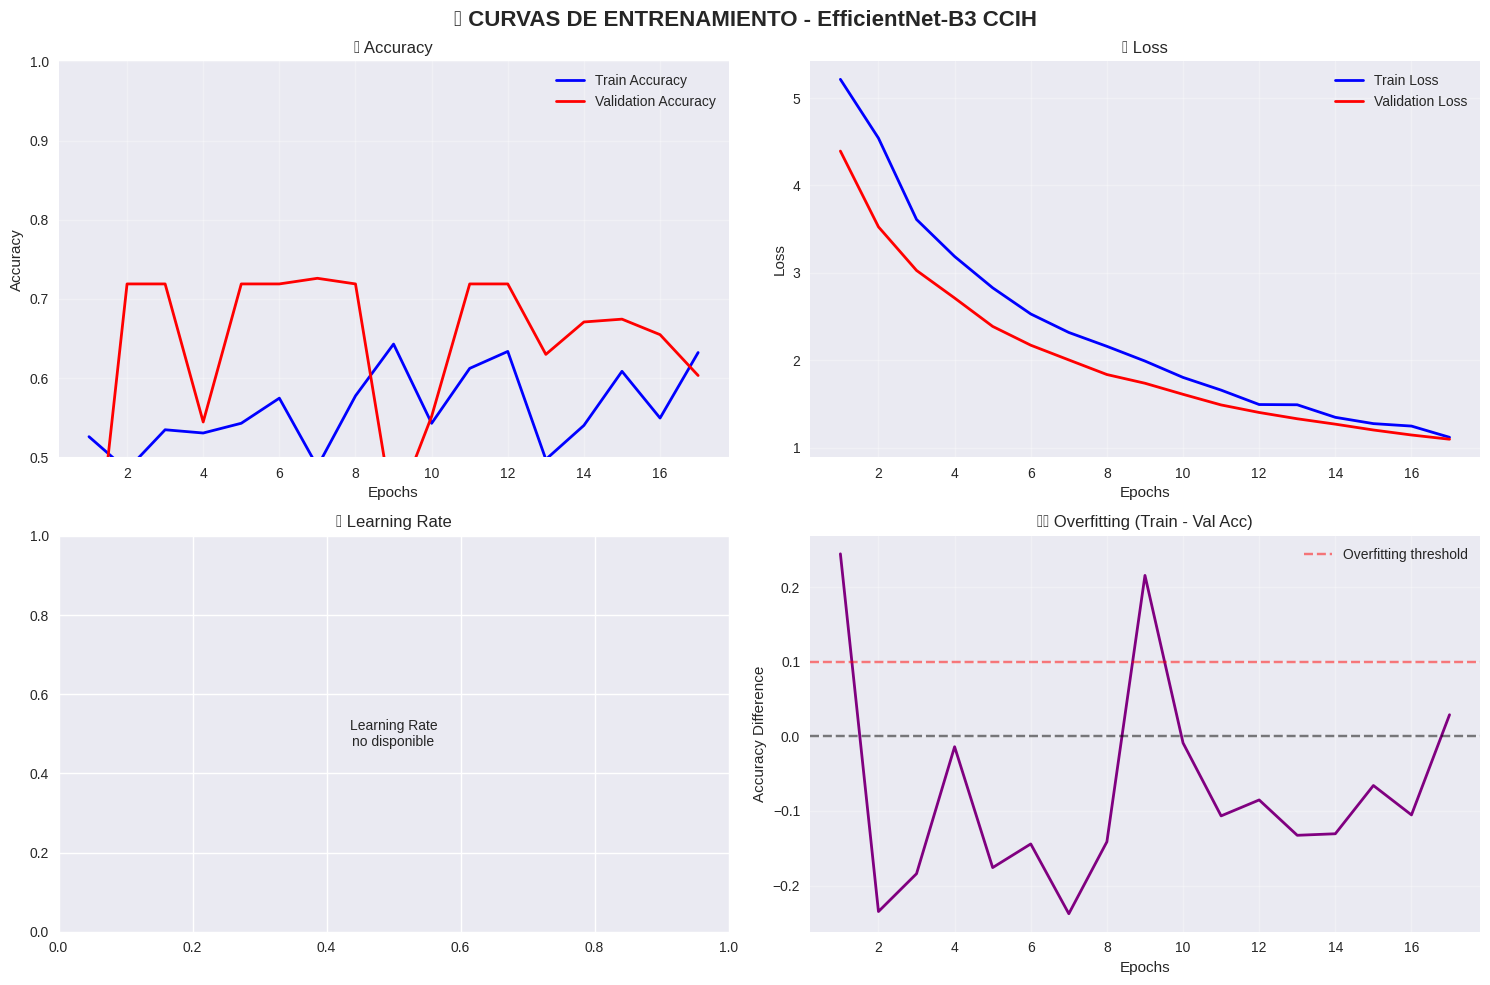


✅ BLOQUE 5 COMPLETADO: ENTRENAMIENTO EXITOSO
🎯 RESULTADO FINAL:
   🏆 Mejor Validation Accuracy: 72.6%
   📊 Epochs entrenados: 17
   💾 Modelo guardado: best_efficientnet_b3_ccih.h5

🚀 PRÓXIMOS PASOS:
   1. 🧪 Bloque 6: Evaluación en conjunto de test
   2. 📊 Análisis de confusión y métricas detalladas
   3. 🔍 Interpretabilidad del modelo (Grad-CAM)
   4. 🎯 Inferencia en nuevas imágenes

📝 Datos guardados para evaluación posterior
🎉 ¡MODELO LISTO PARA DETECTAR ACCIDENTES VEHICULARES!


In [ ]:
print("ENTRENAMIENTO DEL MODELO...")

import time
from datetime import datetime
import numpy as np
import os

pipeline_config['train_generator'].reset()
pipeline_config['valid_generator'].reset()

class TrainingMonitor(tf.keras.callbacks.Callback):
    """Callback personalizado para monitoreo detallado del entrenamiento"""
    
    def __init__(self):
        super().__init__()
        self.epoch_start_time = None
        self.best_val_acc = 0.0
        self.best_epoch = 0
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\nepoca N. {epoch + 1}/{Config.EPOCHS}")
        print("="*50)
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time
        
        # Extraer métricas
        train_loss = logs.get('loss', 0)
        train_acc = logs.get('accuracy', 0)
        train_precision = logs.get('precision', 0)
        train_recall = logs.get('recall', 0)
        
        val_loss = logs.get('val_loss', 0)
        val_acc = logs.get('val_accuracy', 0)
        val_precision = logs.get('val_precision', 0)
        val_recall = logs.get('val_recall', 0)
        
        # Calcular F1-score
        def calculate_f1(prec, rec):
            if prec + rec == 0:
                return 0
            return 2 * (prec * rec) / (prec + rec)
        
        train_f1 = calculate_f1(train_precision, train_recall)
        val_f1 = calculate_f1(val_precision, val_recall)
        
        # Tracking del mejor modelo
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.best_epoch = epoch + 1
            improvement = "Mejor modelo"
        else:
            improvement = f"(mejor: {self.best_val_acc:.4f} en epoch {self.best_epoch})"
        
        # Mostrar métricas
        print(f"Duración: {epoch_duration:.1f}s")
        print(f"TRAIN  → Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Prec: {train_precision:.4f} | Rec: {train_recall:.4f} | F1: {train_f1:.4f}")
        print(f"VALID  → Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_precision:.4f} | Rec: {val_recall:.4f} | F1: {val_f1:.4f}")
        print(f"{improvement}")
        
        # Análisis de overfitting
        if train_acc - val_acc > 0.1:
            print("Posible overfitting detectado")
        elif val_acc > train_acc:
            print("Generalización excelente")
        
        print("="*50)
    
    def on_train_begin(self, logs=None):
        print("ENTRENAMIENTO INICIADO!")
        print(f"Hora de inicio: {datetime.now().strftime('%H:%M:%S')}")
        
    def on_train_end(self, logs=None):
        print("\nENTRENAMIENTO COMPLETADO!")
        print(f"Hora de finalización: {datetime.now().strftime('%H:%M:%S')}")
        print(f"Mejor accuracy: {self.best_val_acc:.4f} (Epoch {self.best_epoch})")

# Añadir monitor personalizado a callbacks
training_monitor = TrainingMonitor()
callbacks_with_monitor = callbacks + [training_monitor]

print(f"\nCALLBACKS ACTIVOS ({len(callbacks_with_monitor)}):")
for i, callback in enumerate(callbacks_with_monitor, 1):
    print(f"   {i}. {callback.__class__.__name__}")


print(f"\nINICIANDO ENTRENAMIENTO...")
print("=" * 70)

# Tiempo de inicio
start_time = time.time()
training_start = datetime.now()

try:
    # ENTRENAMIENTO PRINCIPAL
    history = model.fit(
        pipeline_config['train_generator'],
        
        # Configuración de epochs y steps
        epochs=Config.EPOCHS,
        steps_per_epoch=pipeline_config['steps_per_epoch'],
        
        # Validación
        validation_data=pipeline_config['valid_generator'],
        validation_steps=pipeline_config['validation_steps'],
        
        # Callbacks (incluye monitor personalizado)
        callbacks=callbacks_with_monitor,
        
        # Configuración adicional
        verbose=1,  # Mostrar progreso detallado
        class_weight=pipeline_config['class_weights'],  # None si balanceado
        
        # Shuffling
        shuffle=True  # Shuffle automático entre epochs
    )
    
    # Tiempo de finalización
    training_duration = time.time() - start_time
    training_end = datetime.now()
    
    print("\n" + "="*70)
    print("ENTRENAMIENTO EXITOSO!")
    print("="*70)
    print(f"⏱Duración total: {training_duration / 60:.1f} minutos")
    print(f"Inicio: {training_start.strftime('%H:%M:%S')}")
    print(f"Fin: {training_end.strftime('%H:%M:%S')}")
    
except Exception as e:
    print(f"\nERROR DURANTE EL ENTRENAMIENTO:")
    print(f"Error: {str(e)}")
    print("Revisando configuración...")
    
    # Diagnóstico en caso de error
    try:
        print("\nDIAGNÓSTICO:")
        print(f"Generador train válido: {pipeline_config['train_generator'] is not None}")
        print(f"Generador valid válido: {pipeline_config['valid_generator'] is not None}")
        print(f"Modelo compilado: {model.compiled}")
        print(f"Clases en generador: {pipeline_config['train_generator'].class_indices}")
        print(f"Samples por batch: {pipeline_config['train_generator'].batch_size}")
    except Exception as diag_error:
        print(f"Error en diagnóstico: {diag_error}")
        pass
    
    # Re-lanzar el error para debugging
    raise e


if 'history' in locals():
    print("\nANÁLISIS DE RESULTADOS:")
    print("="*50)
    
    # Extraer métricas del history
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Mejores resultados
    best_epoch = np.argmax(val_acc) + 1
    best_val_acc = max(val_acc)
    best_train_acc = train_acc[best_epoch - 1]
    
    final_val_acc = val_acc[-1]
    final_train_acc = train_acc[-1]
    
    print(f"MEJORES RESULTADOS:")
    print(f"Mejor época: {best_epoch}")
    print(f"Mejor val accuracy: {best_val_acc:.4f}")
    print(f"Train accuracy (mejor época): {best_train_acc:.4f}")
    print(f"Gap (overfitting): {best_train_acc - best_val_acc:.4f}")
    
    print(f"\nRESULTADOS FINALES:")
    print(f"Val accuracy final: {final_val_acc:.4f}")
    print(f"Train accuracy final: {final_train_acc:.4f}")
    print(f"Gap final: {final_train_acc - final_val_acc:.4f}")
    
    
    print(f"\nEVALUACIÓN: {performance}")

    if os.path.exists(Config.MODEL_SAVE_PATH):
        model_size = os.path.getsize(Config.MODEL_SAVE_PATH) / (1024**2)
        print(f"\n💾 MODELO GUARDADO:")
        print(f"   📁 Archivo: {Config.MODEL_SAVE_PATH}")
        print(f"   📊 Tamaño: {model_size:.1f} MB")
        print(f"   🎯 Accuracy: {best_val_acc:.4f}")


if 'history' in locals():
    def plot_training_curves():
        """Visualiza las curvas de entrenamiento"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('CURVAS DE ENTRENAMIENTO - EfficientNet-B3 CCIH', fontsize=16, fontweight='bold')
        
        epochs_range = range(1, len(train_acc) + 1)
        
        # Accuracy
        axes[0, 0].plot(epochs_range, train_acc, 'b-', label='Train Accuracy', linewidth=2)
        axes[0, 0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim([0.5, 1.0])
        
        # Loss
        axes[0, 1].plot(epochs_range, train_loss, 'b-', label='Train Loss', linewidth=2)
        axes[0, 1].plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
        axes[0, 1].set_title('Loss')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Learning Rate (si está disponible)
        if 'lr' in history.history:
            axes[1, 0].plot(epochs_range, history.history['lr'], 'g-', linewidth=2)
            axes[1, 0].set_title('Learning Rate')
            axes[1, 0].set_xlabel('Epochs')
            axes[1, 0].set_ylabel('Learning Rate')
            axes[1, 0].set_yscale('log')
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'Learning Rate\nno disponible', 
                          ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Learning Rate')
        
        # Diferencia Train-Val (Overfitting)
        overfitting = [t - v for t, v in zip(train_acc, val_acc)]
        axes[1, 1].plot(epochs_range, overfitting, 'purple', linewidth=2)
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Overfitting threshold')
        axes[1, 1].set_title('Overfitting (Train - Val Acc)')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Accuracy Difference')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    print(f"\nGENERANDO VISUALIZACIONES...")
    plot_training_curves()